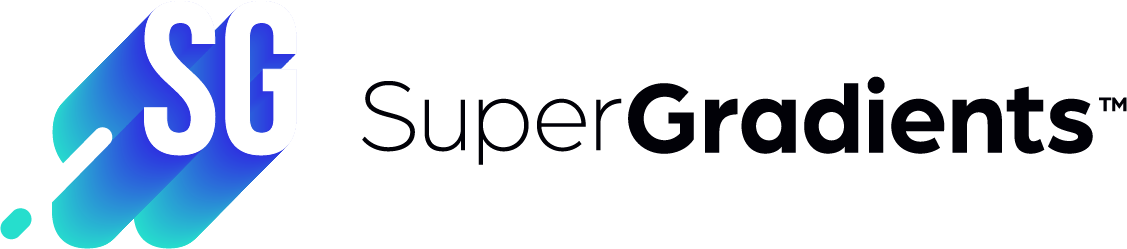


#Super Gradients Tutorial: Enhancing Object Detection, Segmentation, and Classification with Albumentations

Welcome to the Super Gradients tutorial notebook! In this guide, we will explore the seamless integration of Albumentations, a powerful image augmentation library, with Super Gradients, our open-source deep learning framework.

## Introduction

SuperGradients simplifies and enriches the development of deep learning models, offering a comprehensive set of tools for various computer vision tasks. Albumentations, on the other hand, is widely acclaimed for its diverse set of image augmentation techniques, making it an ideal companion for enhancing training data diversity.

In this tutorial, we will demonstrate how to harness the synergy between Super Gradients and Albumentations for three essential computer vision tasks:

1. **Object Detection**
2. **Image Segmentation**
3. **Image Classification**

## Prerequisites

Before we embark on our exploration, ensure you have the necessary libraries installed:


In [ ]:
! pip install git+https://github.com/Deci-AI/super-gradients.git@master
! pip install albumentations
! pip install -qq datasets[vision]~=2.1 pandas~=2.0

  Cloning https://github.com/Deci-AI/super-gradients.git (to revision master) to /tmp/pip-req-build-192k7gwd
  Running command git clone --filter=blob:none --quiet https://github.com/Deci-AI/super-gradients.git /tmp/pip-req-build-192k7gwd
  Resolved https://github.com/Deci-AI/super-gradients.git to commit 6436e4280dc93ef254889683050791d9948457d4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.5/684.5 kB 28.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 53.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.6/408.6 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 14.1 MB/s

## Getting Started

For each task, our tutorial will cover the following key steps:
0. Download and Data Setup
1. Importing Super Gradients and Albumentations.
2. Setting up data pipelines for object detection, segmentation, and classification.
3. Visualizing results.

Let's dive into the integration of Albumentations with Super Gradients to unlock the full potential of your computer vision workflows!

## Dataset Setup - Object Detection

In [ ]:
# @title
from datasets import load_dataset

dataset = load_dataset("cppe-5")
CLASS_NAMES = dataset["train"].features["objects"].feature["category"].names
NUM_CLASSES = len(CLASS_NAMES)
from tqdm import tqdm
import cv2
import numpy as np
import json
import os


def convert_hf_to_coco(dataset_split, output_images_directory, output_annotation_json):
    class_names = dataset["train"].features["objects"].feature["category"].names

    coco_annotation = {
        "images": [],
        "annotations": [],
        "categories": [{"supercategory": name, "name": name, "id": category_id} for category_id, name in enumerate(class_names)],
    }

    os.makedirs(output_images_directory, exist_ok=True)

    annotation_id = 1

    for sample in tqdm(dataset_split):
        image_id = sample["image_id"]
        image = np.array(sample["image"])

        objects = sample["objects"]
        areas = objects["area"]
        bboxes = objects["bbox"]  # XYWH
        category_ids = objects["category"]

        for object_area, object_bbox, object_category in zip(areas, bboxes, category_ids):
            coco_annotation["annotations"].append(
                {
                    "id": annotation_id,
                    "category_id": object_category,
                    "area": float(object_area),
                    "iscrowd": 0,
                    "image_id": image_id,
                    "bbox": list(map(int, object_bbox)),
                }
            )
            annotation_id += 1

        filename = f"{image_id}.jpg"
        output_image_path = os.path.join(output_images_directory, filename)
        cv2.imwrite(output_image_path, image[..., ::-1])  # RGB to BGR

        coco_annotation["images"].append({"file_name": filename, "height": image.shape[0], "width": image.shape[1], "id": image_id})

    with open(output_annotation_json, "w") as f:
        json.dump(coco_annotation, f)


convert_hf_to_coco(dataset["train"], "cppe-5-coco/images/train", "cppe-5-coco/train_annotations.coco.json")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/29 [00:00<?, ? examples/s]

100%|██████████| 1000/1000 [01:37<00:00, 10.22it/s]


## Transforms Setup

Im SG, we often pass un-instantiated objects as mappings, that will be initialized further down the road using [factories](https://github.com/Deci-AI/super-gradients/blob/master/documentation/source/Recipes_Factories.md). This allows us to easily configure objects in our yaml configuration files which are used to launch [training recipes](https://github.com/Deci-AI/super-gradients/blob/master/documentation/source/Recipes_Training.md).

The syntax for using dictionaries instead of yaml files for uninstantiated objects is as follows: `{CLASSNAME : {ARG1: ...,ARG2:...}`

In order to differentiate between Albumentation transforms, we extended our syntax:

`{Albumentations:
   {Compose:
     {transforms:
      [{TRANSFORM1:{ARG: ...}},
       {TRANSFORM2 {ARG, ...}},
       ...
      ]}}}
        `
Reminder: When working with Yaml configuration files this would become:
```yaml\

Albumentations:
  Compose:
    transforms:
      - TRANSFORM1:
         ARG:...
      - TRANSFORM2:
         ARG:...
      ...
```


So let's start with visualizing a simple albumentations pipeline of `Rotate` followed by `RandomBrightnessContrast`:

The console stream is logged into /root/sg_logs/console.log


[2024-01-07 13:27:25] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2024-01-07 13:27:26] WARNING - __init__.py - Failed to import pytorch_quantization
[2024-01-07 13:28:01] WARNING - calibrator.py - Failed to import pytorch_quantization
[2024-01-07 13:28:01] WARNING - export.py - Failed to import pytorch_quantization
[2024-01-07 13:28:01] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2024-01-07 13:28:01] INFO - env_sanity_check.py - Library check is not supported when super_gradients installed through "git+https://github.com/..." command
[2024-01-07 13:28:01] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations:   0%|          | 0/1000 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


Indexing dataset annotations: 100%|██████████| 1000/1000 [00:00<00:00, 1758.89it/s]


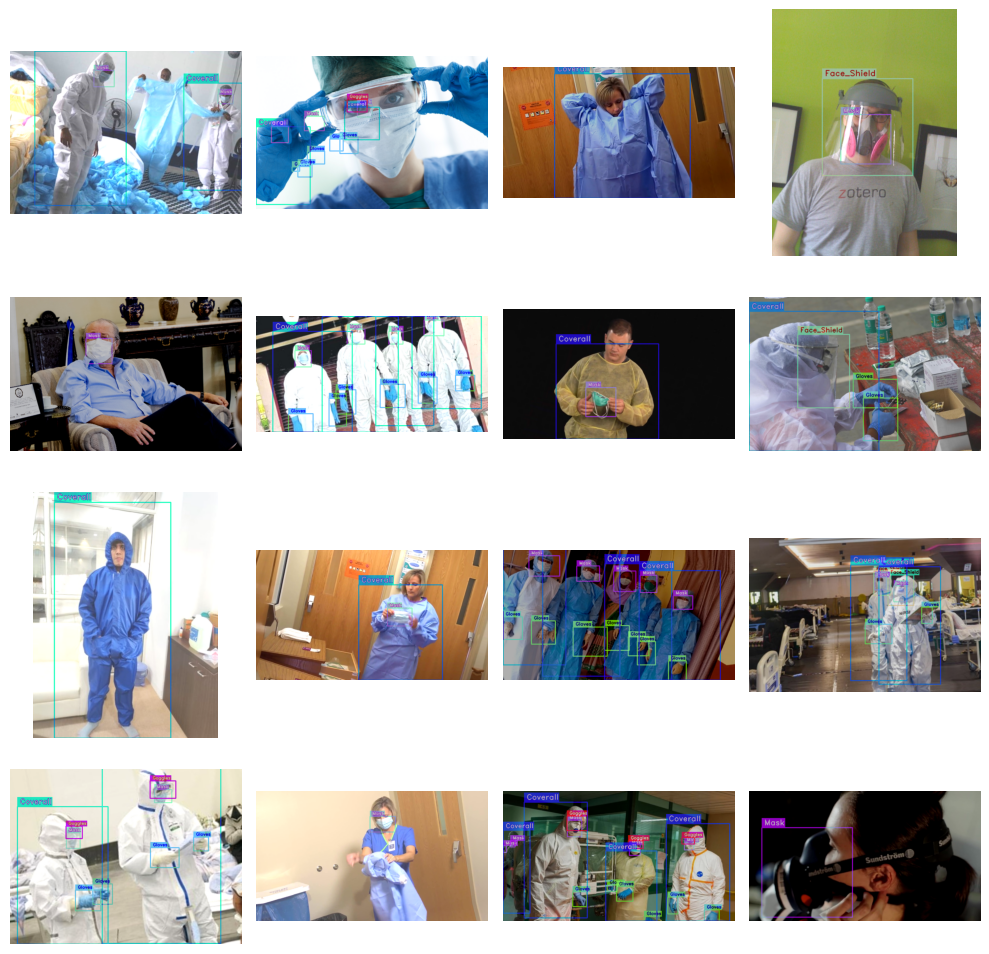

In [ ]:
from super_gradients.training.datasets.detection_datasets.coco_format_detection import COCOFormatDetectionDataset
from super_gradients.training.transforms.transforms import (
    DetectionRandomAffine,
    DetectionHSV,
    DetectionHorizontalFlip,
    DetectionPaddedRescale,
    DetectionStandardize,
    DetectionTargetsFormatTransform,
)
from super_gradients.training.utils.collate_fn import DetectionCollateFN
from super_gradients.training.datasets.datasets_utils import worker_init_reset_seed


train_dataset_params = dict(
    data_dir="cppe-5-coco",
    images_dir="images/train",
    json_annotation_file="train_annotations.coco.json",
    input_dim=(640, 640),
    ignore_empty_annotations=False,
    with_crowd=False,
    all_classes_list=CLASS_NAMES,
    transforms = [
                {
                    "Albumentations": {
                        "Compose": {
                            "transforms": [{"Rotate": {"p": 1., "limit": 15}}, {"RandomBrightnessContrast": {"p": 1.}}],
                            "bbox_params": {"min_area": 1, "min_visibility": 0, "min_width": 0, "min_height": 0, "check_each_transform": True},
                        },
                    }
                },
            ]
)


trainset = COCOFormatDetectionDataset(**train_dataset_params)
trainset.plot()

## Combining SG's native transforms with Albumentations

We can also mix our pipeline up with both Albumentation transforms and SG native transforms, like `DetectionMosaic` and `DetectionMixup`:

[2024-01-07 13:28:07] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.


loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


Indexing dataset annotations: 100%|██████████| 1000/1000 [00:00<00:00, 2105.54it/s]


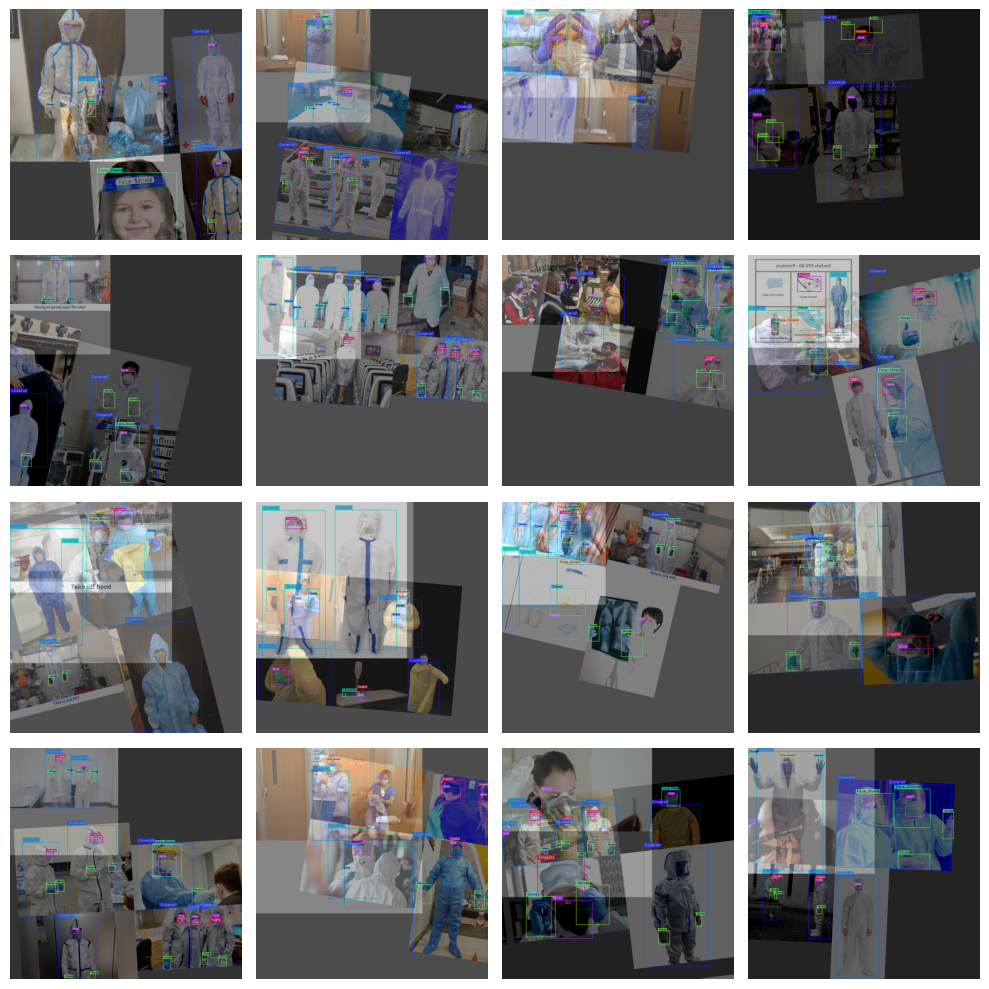

In [ ]:
train_dataset_params["transforms"] = [

                    {"DetectionMosaic": {"input_dim": [640, 640], "prob": 1.0}},

                    {
                        "Albumentations": {
                            "Compose": {
                                "transforms": [{"Rotate": {"p": 1., "limit": 15}}, {"RandomBrightnessContrast": {"p": 1.}}],
                                "bbox_params": {"min_area": 1, "min_visibility": 0, "min_width": 0, "min_height": 0, "check_each_transform": True},
                            },
                        }
                    },

                    {
                        "DetectionMixup": {
                            "input_dim": [640, 640],
                            "mixup_scale": [0.5, 1.5],
                            # random rescale range for the additional sample in mixup
                            "prob": 1.0,  # probability to apply per-sample mixup
                            "flip_prob": 0.5,
                        }
                    },

                ]


trainset = COCOFormatDetectionDataset(**train_dataset_params)
trainset.plot()

## Classification

Working with classification is as simple. Let's demonstrate a simple Albumentations pipeline with our Cifar10 dataset:

In [ ]:
# @title
import matplotlib.pyplot as plt


def plot_classification(dataset, max_samples_per_plot: int = 16, n_plots: int = 1):
    """
    Combine samples of images with class labels into plots and display the result.

    :param dataset:                Classification dataset object
    :param max_samples_per_plot:   Maximum number of images to be displayed per plot
    :param n_plots:                Number of plots to display
    :return:
    """
    plot_counter = 0

    for plot_i in range(n_plots):
        fig = plt.figure(figsize=(10, 10))
        n_subplot = int(np.ceil(max_samples_per_plot**0.5))
        for img_i in range(max_samples_per_plot):
            index = img_i + plot_i * max_samples_per_plot

            image, label = dataset[index]

            ax = plt.subplot(n_subplot, n_subplot, img_i + 1)
            ax.imshow(image)
            ax.set_title(f'{dataset.classes[label]}', color='r', fontsize=10)
            plt.axis("off")

        fig.tight_layout()
        plt.show()
        plt.close()

        plot_counter += 1
        if plot_counter == n_plots:
            return

100%|██████████| 170498071/170498071 [00:01<00:00, 91867955.13it/s]


Extracting ./data/cifar10/cifar-10-python.tar.gz to ./data/cifar10


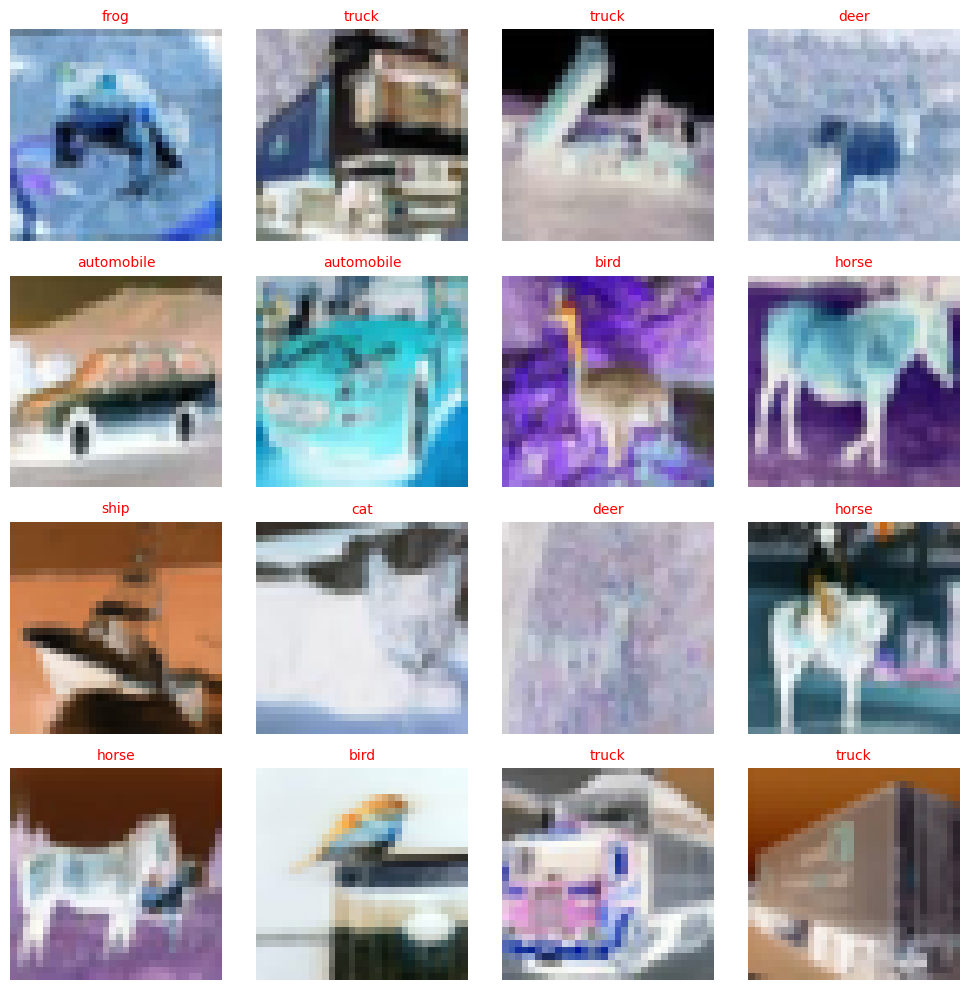

In [ ]:
from super_gradients.training.datasets import Cifar10

dataset = Cifar10(
            root="./data/cifar10",
            train=True,
            download=True,
            transforms={"Albumentations": {"Compose": {"transforms": [{"HorizontalFlip": {"p": 1.0}}, {"InvertImg": {"p": 1.0}}]}}},
        )
plot_classification(dataset)

##Segmentation

Finally, lets do the same for segmentation.
For the sake of this tutorial we use the [Supervisely persons dataset](https://datasetninja.com/supervisely-persons).


In [ ]:
# @title
import os

SUPERVISELY_DATASET_DOWNLOAD_PATH=os.path.join(os.getcwd(),"data")

supervisely_dataset_dir_path = os.path.join(SUPERVISELY_DATASET_DOWNLOAD_PATH, 'supervisely-persons')

if os.path.isdir(supervisely_dataset_dir_path):
    print('supervisely dataset already downloaded...')
else:
    print('Downloading and extracting supervisely dataset to: ' + SUPERVISELY_DATASET_DOWNLOAD_PATH)
    ! mkdir $SUPERVISELY_DATASET_DOWNLOAD_PATH
    %cd $SUPERVISELY_DATASET_DOWNLOAD_PATH
    ! wget https://deci-pretrained-models.s3.amazonaws.com/supervisely-persons.zip
    ! unzip --qq supervisely-persons.zip

mkdir: cannot create directory ‘/content/data’: File exists
/content/data
--2024-01-07 13:28:29--  https://deci-pretrained-models.s3.amazonaws.com/supervisely-persons.zip
Resolving deci-pretrained-models.s3.amazonaws.com (deci-pretrained-models.s3.amazonaws.com)... 52.217.112.185, 54.231.137.73, 52.217.84.60, ...
Connecting to deci-pretrained-models.s3.amazonaws.com (deci-pretrained-models.s3.amazonaws.com)|52.217.112.185|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3564001012 (3.3G) [application/zip]
Saving to: ‘supervisely-persons.zip’

supervisely-persons 100%[===================>]   3.32G  58.9MB/s    in 55s     

2024-01-07 13:29:24 (61.8 MB/s) - ‘supervisely-persons.zip’ saved [3564001012/3564001012]



In [ ]:
# @title
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch

def visualize_image(image):
    """
    Visualize the input image.

    :param image: torch.Tensor representing the input image with values between 0 and 1. Shape: (C, H, W).
    """
    # Convert torch tensor to numpy array
    image_np = image.permute(1, 2, 0).cpu().numpy()  # Change shape from (C, H, W) to (H, W, C)

    # Display the image
    plt.imshow(image_np)
    plt.axis("off")
    plt.show()


def visualize_mask(mask, num_classes=None, class_colors=None):
    """
    Visualize the segmentation mask.

    :param mask: torch.Tensor representing the segmentation mask with class indices. Shape: (H, W).
    :param num_classes: Number of classes in the segmentation mask.
    :param class_colors: A dictionary mapping class indices to RGB color values.
    """
    # Convert torch tensor to numpy array
    mask_np = mask.cpu().numpy()

    # Determine the number of classes
    if num_classes is None:
        num_classes = int(torch.max(mask) + 1)

    # Define default class colors if not provided
    if class_colors is None:
        class_colors = {i: plt.cm.tab10(i)[:-1] for i in range(num_classes)}  # Exclude the alpha channel

    # Create a colormap for visualization
    colormap = ListedColormap([class_colors[i] for i in range(num_classes)])

    # Display the mask
    plt.imshow(mask_np, cmap=colormap)
    plt.colorbar(ticks=range(num_classes))
    plt.axis("off")
    plt.show()


def visualize_segmentation_batch(dataset, batch_size=8, num_classes=2):
    """
    Visualize a batch of images and masks from a segmentation dataset.

    :param dataset: Segmentation dataset object.
    :param batch_size: Number of samples in the batch.
    """
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Fetch a single batch
    images, masks = next(iter(dataloader))

    for i in range(batch_size):
        image = images[i]
        mask = masks[i]

        # Visualize image
        print(f"Image {i+1} in the batch:")
        visualize_image(image)

        # Visualize mask
        print(f"Mask {i+1} in the batch:")
        visualize_mask(mask, num_classes=num_classes)  # Assuming the dataset has a num_classes attribute




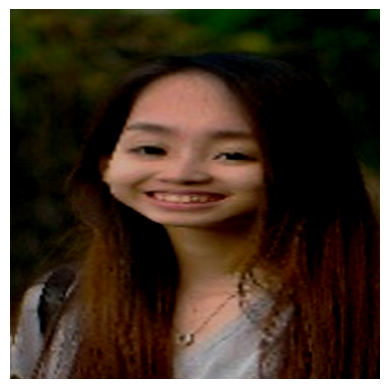

Image 1 in the batch:


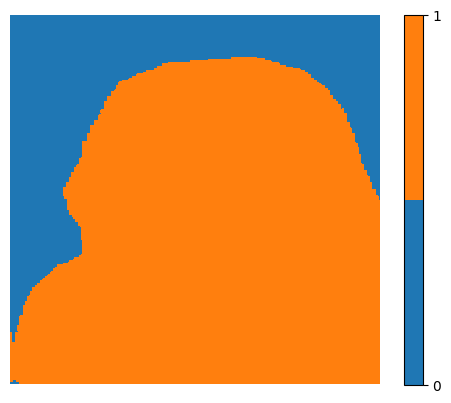

Mask 1 in the batch:
Image 2 in the batch:


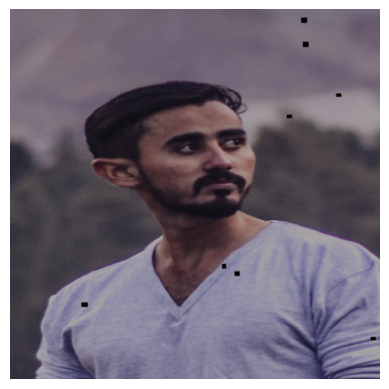

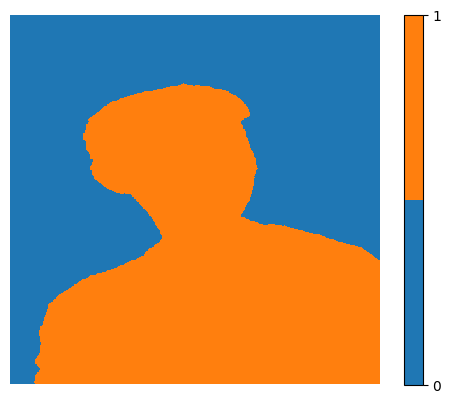

Mask 2 in the batch:
Image 3 in the batch:


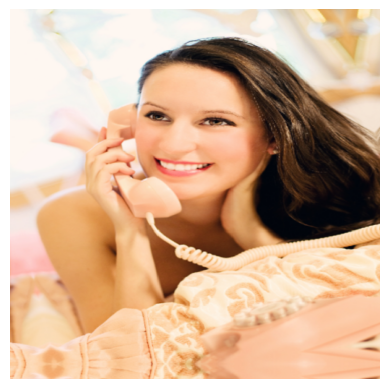

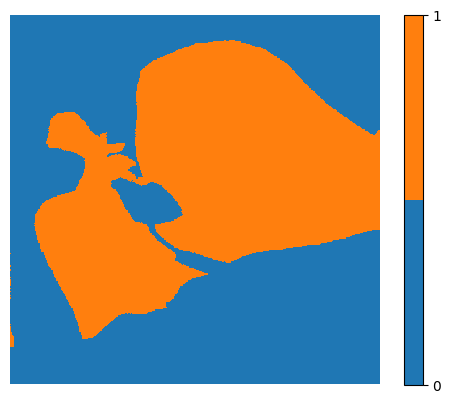

Mask 3 in the batch:
Image 4 in the batch:


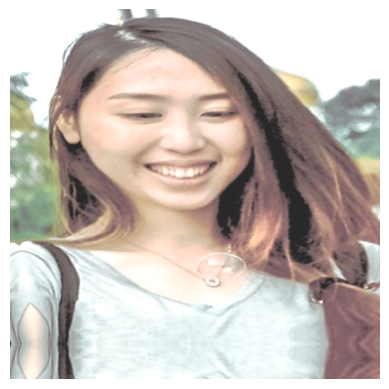

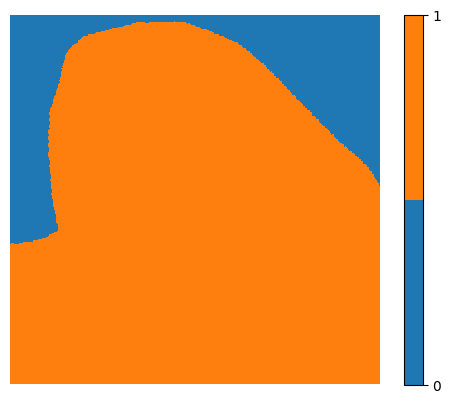

Mask 4 in the batch:
Image 5 in the batch:


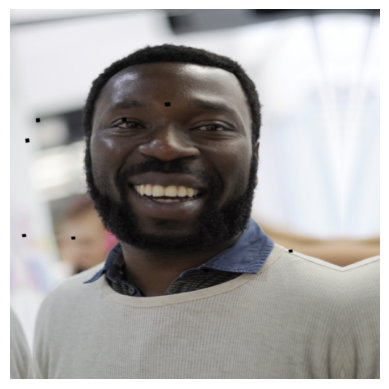

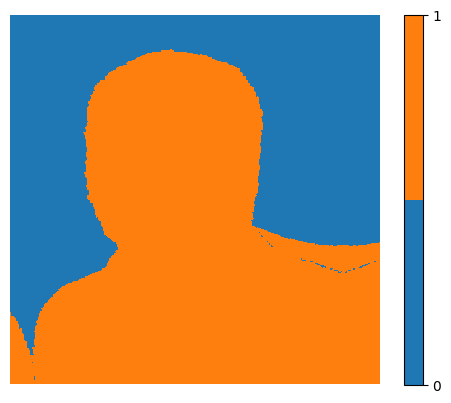

Mask 5 in the batch:
Image 6 in the batch:


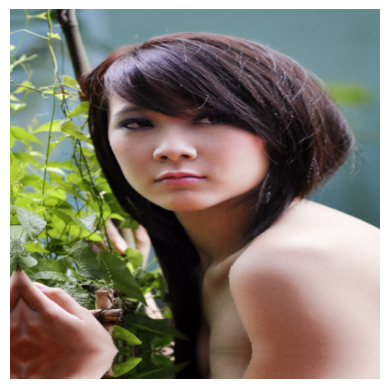

Mask 6 in the batch:


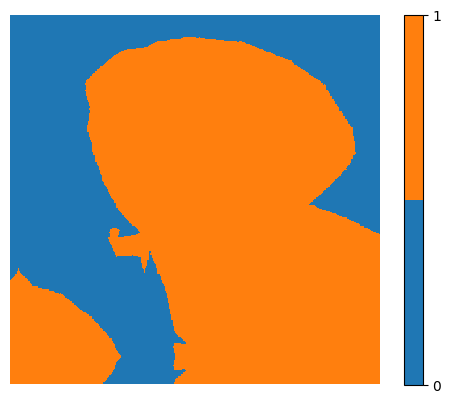

Image 7 in the batch:


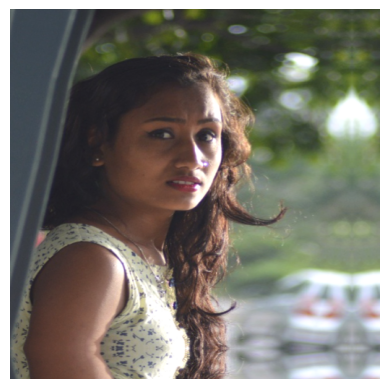

Mask 7 in the batch:


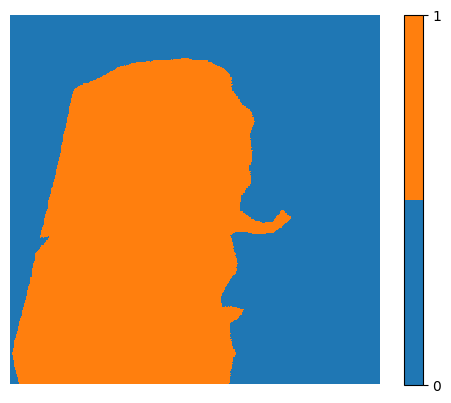

Image 8 in the batch:


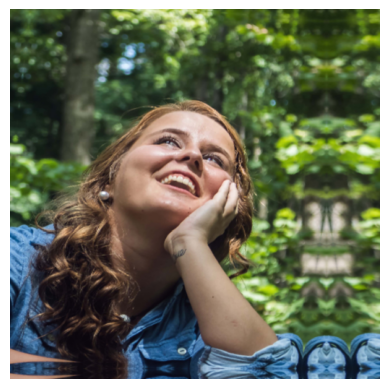

Mask 8 in the batch:


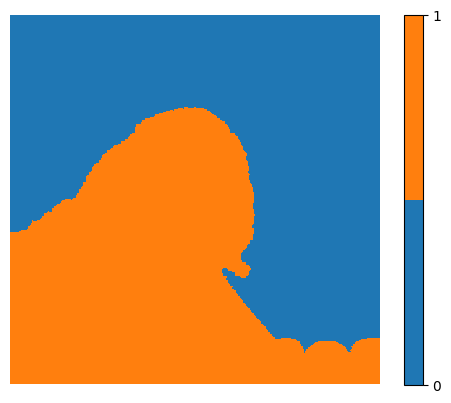

In [24]:
from super_gradients.training.datasets import SuperviselyPersonsDataset

transforms = [
                {
                    "Albumentations": {
                        "Compose": {"transforms": [
                            "CoarseDropout",
                            {"Rotate": {"p": 1., "limit": 15}},
                            {"GridDistortion": {"p": 1.}},
                            {"RandomBrightnessContrast": {"p": 0.5}},
                            {"Resize":{"width": 512, "height": 512}}
                        ]},
                    }
                },
                {"SegStandardize":
                 {"max_value": 255}},
                "SegConvertToTensor",
            ]
dataset_params = {'root_dir': '/content/data/supervisely-persons', 'list_file': 'train.csv', 'cache_labels': False, 'cache_images': False, "transforms": transforms}

dataset = SuperviselyPersonsDataset(**dataset_params)

visualize_segmentation_batch(dataset)